### Read sample data

The test last for 30 minutes, there are a total of 2 - 4 channels to be measured. Measurement is done every 20 seconds on all channels. Currently we have 2 channel, but in the future we will have 4 channel.

At each measuremnt, a total of 120 data point is collected. Measurement on 1 channel normally takes less than 1-2 seconds.

This sample data is the data collected on 1 channel during the test. It is a list of 90 measurements. For each measurement, it consits of a start/end potential for this measurement and 120 current data.

For example, the first measurement: 

```
[
    [
      -0.407,
      0.193
    ],
    [
      7.952,
      9.462,
      9.058,
      .
      .
      .
    ],
    ...
```

The starting potential is -.407V, ending potential is 0.193V, 120 data point is collected. Current values are 7.952... etc.

In [1]:
# load the data.
import json
data = json.load(open('./sample.json'))

### perform data analysis to find the measurement value at each measurement

The operation is done in real time, whenever a measurement is finished, the raw data is processed to generate the fitting result. The raw data can be discarded, only store the fitting result.



In [2]:
# the peak fitting algorithm is in the util module. 
# you can look in to details. 
# certain algorithms from python packages are used. We need to migrate those algorithms as well.

from util import myfitpeak,plotFit
import numpy as np

fits = []
for v,a in data:
    fits.append(myfitpeak(np.linspace(*v,len(a)),a))


In [7]:
print(json.dumps(fits[-1],indent=2))

{
  "fx": [
    -0.28173949579831936,
    0.0006134453781512228
  ],
  "fy": [
    6.842783185604062,
    5.293803910028376
  ],
  "pc": 11.246700978340783,
  "pv": -0.1355210084033614,
  "err": 0.033890667563091136
}


### Fitting result
- `pc` is the peak high in the figure below.(green verticle line). This is the value we use for downstream calling.
- `fx, fy` are the cordinates of the peak base. (left and right intersection point of the orange line)
- `pv` is the peak center.
- `err` is a estimation of how close the peak is to a normal distribution. 

<AxesSubplot:>

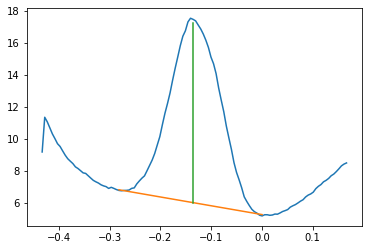

In [9]:
# This is demonstrating how the raw measurement and one of fitting result looks like 
plotFit(np.linspace(*v,len(a)) , a, fits[-1] )

### Perform the result calling from the time course result

The `pc` value at each measurement from the previous step is used to predict whether the channel is positive or negative.

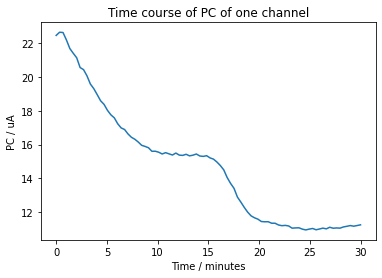

In [18]:
# Here is how the time course curve normally looks like
# plotting is just for show here.
import matplotlib.pyplot as plt
plt.plot( np.linspace(0,30,len(fits)) ,  [i['pc'] for i in fits])
plt.ylabel('PC / uA')
plt.xlabel('Time / minutes')
plt.title('Time course of PC of one channel')
plt.show()

In [24]:

from util import hCtTPredictT,convert_list_to_X

# t is the time points, the measurement is taken over 30 minutes, and a total of len(fits) measurements.
t = np.linspace(0,30,len(fits))
# c is all the `pc` in fitting result
c = [i['pc'] for i in fits]
data = [[t,c]]

# the convert_list_to_X is just to transform the data to the shape that works with the scipy pipeline.
X = convert_list_to_X(data)

# hCtPredictT is the pipeline that transforms and fits the data to give calling result.
result = hCtTPredictT.transform(X)

call, Ct, prominance, signal_drop = result[0]

print(f"The result is {'Positive' if call else 'Negative'}.")
print(f"The reaction Ct is {Ct:.2f} minutes.")
print(f"The prominance is {prominance:.4f}.")
print(f"The signal drop is {signal_drop:.4f}.")

The result is Positive.
The reaction Ct is 16.59 minutes.
The prominance is 1.5733.
The signal drop is 0.2204.


### You can look into the `hCtTPredictT` pipeline to see what calculations are done.

The calculations utilizes some python packages, these functions need to be migrated.